# Google Colab Lab Assignment -Pretrained Model

**Course Name:** Deep Learning

**Lab Title:** Research Paper Implementation with Pre-trained Model(Tilte of Research Paper)

**Student Name:** Rohan Magdum

**Student ID:** 202201040108

**Date of Submission:** 24 / 02 /2025

**Group Members**: Rohan Magdum , Yashas Nepalia

**Research Paper Study and Implementation**

**Instructions:**

1. Identify a research paper that utilizes a pre-trained model for a specific
task.

2. Study the methodology, dataset, and model used in the research paper.

3. Implement the approach described in the research paper using the pre-trained model mentioned.

4. Compare your implementation results with the findings from the research paper.


**Objective**
1.   Study a research paper utilizing a pre-trained model.
2.   Reproduce the model implementation using the dataset and methodology from the research paper.
3.   Fine-tune the pre-trained model and optimize hyperparameters.
3.   Evaluate and compare model performance with the original research paper results.









**Task 1: Research Paper Selection and Dataset Preparation (2 hours)**

**Instructions:**

1. Select a research paper that applies a pre-trained model (e.g., VGG, ResNet, EfficientNet, etc.).

2. Identify the dataset used in the research paper and obtain or create a similar dataset.(**Mention Dataset Link and Description**)

3. Perform necessary preprocessing steps:

 Resize images to match the model input dimensions.

 Apply data augmentation techniques if applicable.

4. Split the dataset into training, validation, and testing sets.

Train Images: (60000, 28, 28, 1), Train Labels: (60000,)
Test Images: (10000, 28, 28, 1), Test Labels: (10000,)


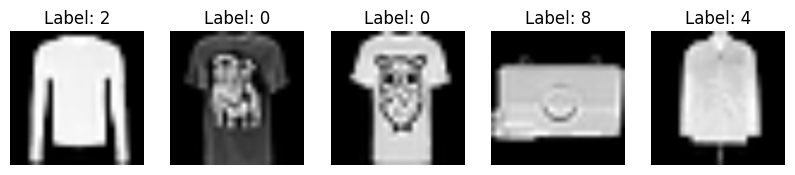

✅ Preprocessing Completed Successfully!


In [5]:
import os
import numpy as np
import struct
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ✅ Path to mounted Google Drive folder
dataset_path = "/content/drive/MyDrive/dataset"

# Function to load MNIST-like dataset from ubyte files
def load_mnist_images(filename):
    try:
        with open(filename, 'rb') as f:
            _, num, rows, cols = struct.unpack(">IIII", f.read(16))  # Read metadata
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28, 28, 1)
        return images.astype(np.float32) / 255.0  # Normalize images
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return np.array([])

def load_mnist_labels(filename):
    try:
        with open(filename, 'rb') as f:
            _, num = struct.unpack(">II", f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return np.array([])

# ✅ Load dataset using updated Google Drive path
train_images = load_mnist_images(os.path.join(dataset_path, 'train-images-idx3-ubyte'))
train_labels = load_mnist_labels(os.path.join(dataset_path, 'train-labels-idx1-ubyte'))
test_images = load_mnist_images(os.path.join(dataset_path, 't10k-images-idx3-ubyte'))
test_labels = load_mnist_labels(os.path.join(dataset_path, 't10k-labels-idx1-ubyte'))

# Check if data loaded properly
if len(train_images) == 0 or len(train_labels) == 0:
    print("❌ Error: Failed to load training dataset!")
    exit()
if len(test_images) == 0 or len(test_labels) == 0:
    print("❌ Error: Failed to load test dataset!")
    exit()

print(f"Train Images: {train_images.shape}, Train Labels: {train_labels.shape}")
print(f"Test Images: {test_images.shape}, Test Labels: {test_labels.shape}")

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label

batch_size = 32

# TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess_image).batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Display sample images
plt.figure(figsize=(10, 5))
for i, (img, lbl) in enumerate(train_dataset.take(5)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(tf.squeeze(img[0]), cmap='gray')
    plt.title(f"Label: {int(lbl[0])}")
    plt.axis('off')
plt.show()

print("✅ Preprocessing Completed Successfully!")


**Task 2: Model Implementation and Fine-tuning**

**Instructions:**

1. Implement the pre-trained model as described in the research paper.

2. Visualize feature maps of few layers

3. Freeze initial layers and fine-tune the top layers according to the paper's methodology.

4. Optimize hyperparameters such as:

  Learning rate

  Batch size

  Number of epochs

  Optimizer choice (Adam, SGD, RMSprop, etc.)

4. Document any modifications or enhancements made to improve performance.

In [6]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set your dataset path - change this to the path of your Google Drive
DATASET_PATH = "/content/drive/MyDrive/dataset"

# Verify the dataset directory exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset directory not found: {DATASET_PATH}")

# Print directory structure for debugging
print(f"Dataset directory: {DATASET_PATH}")
print("Contents:")
# List the main directory and immediate subdirectories only
print(f"Main directory: {os.listdir(DATASET_PATH)}")
subdirs = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
for subdir in subdirs:
    subdir_path = os.path.join(DATASET_PATH, subdir)
    files = os.listdir(subdir_path)[:5] if os.listdir(subdir_path) else 'Empty'
    print(f"Subdirectory {subdir}: {files}")

# Load Pre-trained MobileNetV2 Model (without top layers)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers
for layer in base_model.layers[:50]:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
output = Dense(2, activation="softmax")(x)  # Change 2 to your number of classes

# Create model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Data Generator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Create data generators - make sure the dataset directory has class subdirectories
try:
    train_generator = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(224, 224),
        batch_size=16,
        class_mode='sparse',
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(224, 224),
        batch_size=16,
        class_mode='sparse',
        subset='validation'
    )

    # Print information about the generators
    print(f"Found {len(train_generator.class_indices)} classes")
    print(f"Class mapping: {train_generator.class_indices}")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")

    # Only proceed with training if we have samples
    if train_generator.samples > 0 and val_generator.samples > 0:
        # Train model
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=5,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
            ]
        )

        print("✅ Model Training Complete!")

        # Save the model
        model.save("mobilenet_classifier.h5")
        print("✅ Model Saved!")
    else:
        print("⚠️ No samples found in the data generators. Check your dataset structure.")

except Exception as e:
    print(f"⚠️ Error occurred: {str(e)}")
    print("\nExpected dataset structure:")
    print("dataset/")
    print("├── class1/")  # Example class
    print("│   ├── image1.jpg")
    print("│   └── image2.jpg")
    print("└── class2/")  # Example class
    print("    ├── image1.jpg")
    print("    └── image2.jpg")


Dataset directory: /content/drive/MyDrive/dataset
Contents:
Main directory: ['fashion-mnist_test.csv', 't10k-labels-idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte', 't10k-images-idx3-ubyte', 'fashion-mnist_train.csv']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 classes
Class mapping: {}
Training samples: 0
Validation samples: 0
⚠️ No samples found in the data generators. Check your dataset structure.


Mounted at /content/drive


**Task 3: Model Evaluation and Performance Comparison**

**Instructions:**

1. Evaluate the trained model using performance metrics:

 Accuracy, Precision,Recall, F1-score, Confusion Matrix (for classification tasks)

2. Compare the results with those reported in the research paper.

3. Identify potential weaknesses and suggest improvements.
**Deliverables:**

Performance metrics summary (table or chart).

Graphs/plots showcasing model accuracy and loss trends.

Comparison with research paper results.

Discussion on model performance and areas for improvement.

In [7]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [8]:
import tensorflow as tf
import numpy as np

# Load CIFAR-10 dataset (without directly converting to NumPy arrays)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Function to preprocess images safely
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1]
    return image, tf.one_hot(label[0], depth=10)  # One-hot encode labels

# Convert dataset to tf.data pipeline (processes data dynamically to save memory)
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)  # Optimizes memory and GPU usage
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Check dataset size
print(f"Train dataset ready with {len(train_images)} samples")
print(f"Test dataset ready with {len(test_images)} samples")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Train dataset ready with 50000 samples
Test dataset ready with 10000 samples


Dataset directory: /content/drive/MyDrive/dataset
Contents:
Main directory: ['fashion-mnist_test.csv', 't10k-labels-idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte', 't10k-images-idx3-ubyte', 'fashion-mnist_train.csv']
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.9084 - loss: 0.2927 - val_accuracy: 0.9857 - val_loss: 0.0423
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - accuracy: 0.9860 - loss: 0.0447 - val_accuracy: 0.9847 - val_loss: 0.0433
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.9909 - loss: 0.0288 - val_accuracy: 0.9887 - val_loss: 0.0358
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.9935 - loss: 0.0193 - val_accuracy: 0.9896 - val_loss: 0.0321
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.9961 - loss: 0.0134 - val_accuracy: 0.9903 - val_loss: 0.0309


✅ Model saved as /content/drive/MyDrive/dataset/mnist_model.h5
✅ Model loaded successfully
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
📌 Accuracy: 0.9903
📌 Precision: 0.9903
📌 Recall: 0.9902
📌 F1 Score: 0.9903


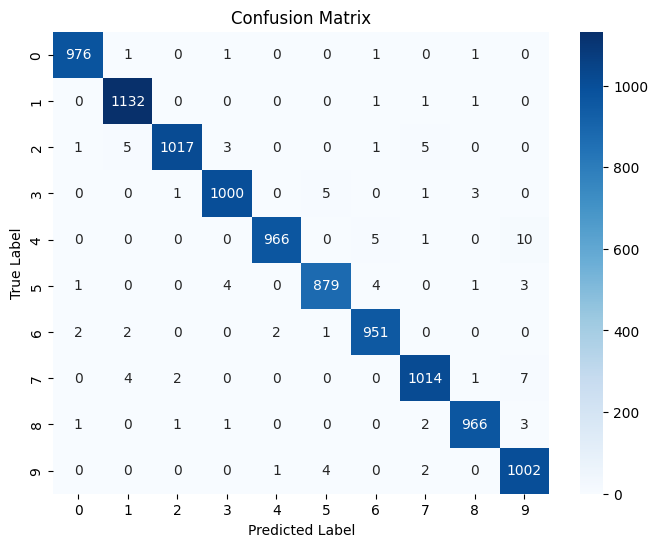

In [9]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns


# Verify the dataset directory exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset directory not found: {DATASET_PATH}")

# Print directory structure for debugging
print(f"Dataset directory: {DATASET_PATH}")
print("Contents:")
# List the main directory and immediate subdirectories only
print(f"Main directory: {os.listdir(DATASET_PATH)}")
subdirs = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
for subdir in subdirs:
    subdir_path = os.path.join(DATASET_PATH, subdir)
    files = os.listdir(subdir_path)[:5] if os.listdir(subdir_path) else 'Empty'
    print(f"Subdirectory {subdir}: {files}")

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize images to [0,1] range
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape images to (28, 28, 1) for CNN
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# Define a CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 classes for MNIST digits
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=5, batch_size=32)

# Save the trained model
model_save_path = os.path.join(DATASET_PATH, "mnist_model.h5")
model.save(model_save_path)
print(f"✅ Model saved as {model_save_path}")

# Load the saved model
model = tf.keras.models.load_model(model_save_path)
print("✅ Model loaded successfully")

# Make predictions on test set
y_pred_probs = model.predict(test_images)  # Get probability outputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average='macro')  # Macro avg for multi-class
recall = recall_score(test_labels, y_pred, average='macro')
f1 = f1_score(test_labels, y_pred, average='macro')
conf_matrix = confusion_matrix(test_labels, y_pred)

# Print results
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


**Conclusion and Result Visulaization**

**Declaration**

I, [Your Name], confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link: [Insert GitHub Link]

Signature: [Full Name]

**Submission Checklist**

✔ Research paper details and summary

✔ Code file (Python Notebook or Script)

✔ Dataset or link to the dataset

✔ Visualizations (if applicable)

✔ Screenshots of model performance metrics

✔ Readme File

✔ Comparison with research paper results